In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from himodule.custom_classes import NasaDataset, SimpleAE, split_dataset, seed_everything
from himodule.ae_metrics import MAPE
from himodule.rul_metrics import RMSELoss
from himodule.normalisation import StandardScaler, MinMaxScaler
from himodule.secondary_funcs import check_path, load_object, save_object

import os

sns.set_theme(style='whitegrid', font_scale=1.2)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [3]:
class LossAndMetric(nn.Module):
    def __init__(self, loss_func: object, metric_func: object, scaler: object = None):
        super(LossAndMetric, self).__init__()
        self.loss_func = loss_func
        self.metric_func = metric_func
        self.scaler = scaler
    
    
    def forward(self, predicted_values: torch.Tensor, true_values: torch.Tensor) -> tuple:
        loss = self.loss_func(predicted_values, true_values)

        if self.scaler:
            metric = self.metric_func(self.scaler.inverse_transform(predicted_values),
                                 self.scaler.inverse_transform(true_values))
        else:
            metric = self.metric_func(predicted_values, true_values)
        
        return loss, metric

In [4]:
seed = 37

train_dataset = NasaDataset('../datasets/clean_train_data.csv')
seed_everything(seed)
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)

test_dataset = NasaDataset('../datasets/clean_test_data.csv')

scaler = MinMaxScaler()
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'
for idx, dtset in enumerate((train_dataset, val_dataset, test_dataset)):
    dtset.to(device)
    if scaler:
        if idx == 0:
            scaler.fit(dtset.dataset)
        dtset.dataset = scaler.transform(dtset.dataset)
    
scaler_path = os.path.join('../scalers/', f'{norm_name}.pkl')
if scaler and not os.path.exists(scaler_path):
    save_object(scaler, scaler_path)

seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)

seed_everything(seed)
test_loader = DataLoader(val_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)

print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (8, 4, 2)

seed_everything(seed)
model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
metric_func = MAPE()
get_loss_and_metric = LossAndMetric(loss_func, metric_func, scaler)
optimiser = optim.AdamW(model_ae.parameters(),
                       lr=1e-3)
optimiser_name = repr(optimiser).split(' ', maxsplit=1)[0]

Train: 15085
Validation: 5546
Test: 13096


In [5]:
def evaluate_model(model: nn.Module, loader: DataLoader, ):
    with torch.no_grad():
        losses = list()
        metrics = list()
        for dta in loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model(sample)

            loss, metric = get_loss_and_metric(reconstruction, sample)

            losses.append(loss.item())
            metrics.append(metric.item())
    return losses, metrics


def plot_history(loss_history_df: pd.DataFrame, metric_history_df: pd.DataFrame,
                 test_losses: float, test_metrics: float,
                 ylabel_loss: str = None, ylabel_metric: str = None, save_path: str = None):
    loss_history_df = loss_history_df.melt(ignore_index=False).iloc[1:]
    metric_history_df = metric_history_df.melt(ignore_index=False).iloc[1:]
    fig = plt.figure(layout="constrained")
    fig.set_size_inches(10, 10)

    gs = GridSpec(2, 5, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0:4])
    ax2 = fig.add_subplot(gs[0, 4])
    
    ax3 = fig.add_subplot(gs[1, 0:4])
    ax4 = fig.add_subplot(gs[1, 4])

    sns.lineplot(data=loss_history_df,
                x=loss_history_df.index,
                y='value',
                hue='variable',
                ax=ax1)
    ax1.set_ylabel(ylabel_loss)

    sns.boxplot(x=['test_loss']*len(test_losses),
                y=test_losses,
                color='g',
                ax=ax2)
    ax2.set_ylabel(None)

    sns.lineplot(data=metric_history_df,
                x=metric_history_df.index,
                y='value',
                hue='variable',
                ax=ax3)
    ax3.set_ylabel(ylabel_metric)

    sns.boxplot(x=['test_metric']*len(test_metrics),
                y=test_metrics,
                color='g',
                ax=ax4)
    ax4.set_ylabel(None)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

 10/100: train_loss=0.0065, val_loss=0.0064, train_metrics=8.4189%, val_metrics=8.2295%
 20/100: train_loss=0.0059, val_loss=0.0059, train_metrics=7.0555%, val_metrics=7.0919%
 30/100: train_loss=0.0058, val_loss=0.0058, train_metrics=5.6251%, val_metrics=5.7740%
 40/100: train_loss=0.0058, val_loss=0.0058, train_metrics=5.0595%, val_metrics=5.2787%
 50/100: train_loss=0.0057, val_loss=0.0057, train_metrics=4.8811%, val_metrics=4.3652%
 60/100: train_loss=0.0057, val_loss=0.0057, train_metrics=4.8360%, val_metrics=4.6648%
 70/100: train_loss=0.0057, val_loss=0.0057, train_metrics=4.8618%, val_metrics=4.5943%
 80/100: train_loss=0.0057, val_loss=0.0057, train_metrics=4.7986%, val_metrics=5.0263%
 90/100: train_loss=0.0057, val_loss=0.0057, train_metrics=4.7467%, val_metrics=4.9590%
100/100: train_loss=0.0057, val_loss=0.0057, train_metrics=4.8553%, val_metrics=4.4930%

test_loss=0.0056, test_metric=4.7995%


C:\Users\Matthew\AppData\Local\Temp\ipykernel_10140\1649938166.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


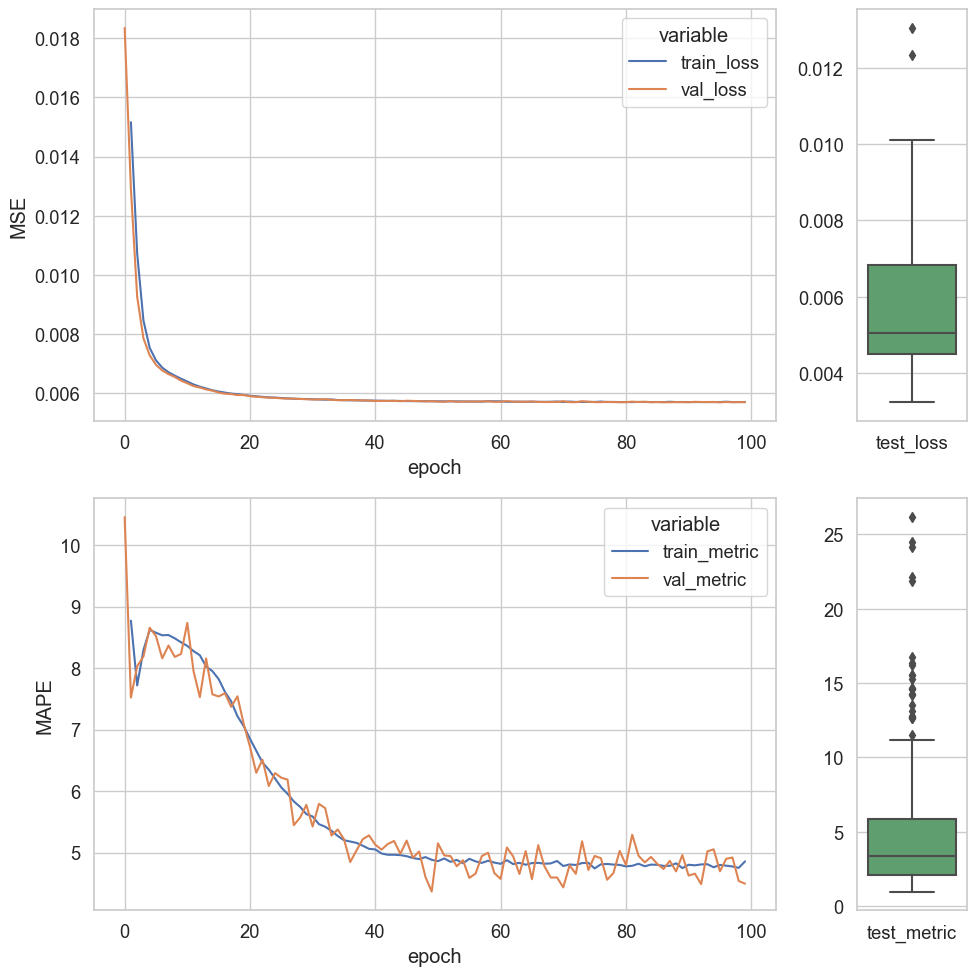

In [6]:
epochs = 100
history = list()

for epoch in range(epochs):
    train_losses = list()
    train_metrics = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss, metric = get_loss_and_metric(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_metrics.append(metric.item())
    
    val_losses, val_metrics = evaluate_model(model_ae, val_loader)
    
    train_loss, val_loss = mean(train_losses), mean(val_losses)
    train_metrics, val_metrics = mean(train_metrics), mean(val_metrics)
    history.append((epoch, train_loss, val_loss, train_metrics, val_metrics))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=:.4f}, {val_loss=:.4f}, {train_metrics=:.4f}%, {val_metrics=:.4f}%')

test_losses, test_metrics = evaluate_model(model_ae, test_loader)
test_loss = mean(test_losses)
test_metric = mean(test_metrics)
print(f'\n{test_loss=:.4f}, {test_metric=:.4f}%')


# -------------------------------------------------- #
name = str(layers_sizes)
models_path = '../Models/'
plot_path = '../Plots/history/'


if True:
    pth = check_path(os.path.join(models_path, optimiser_name, norm_name))
    torch.save(model_ae.state_dict(), os.path.join(pth, f'{name}.pth'))

if True:
    columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
    total_history_df = pd.DataFrame(history, columns=columns).set_index('epoch')

    pth = check_path(os.path.join(plot_path, optimiser_name, norm_name))

    loss_history_df = total_history_df.loc[:,('train_loss', 'val_loss')]
    metric_history_df = total_history_df.loc[:,('train_metric', 'val_metric')]
    plot_history(loss_history_df, metric_history_df, test_losses, test_metrics,
                ylabel_loss='MSE', ylabel_metric='MAPE', save_path=os.path.join(pth, f'{name}.png'))